# Potato Anomaly Detection and Classification
Ce notebook implémente : 
1. Détection d’anomalies (AE)
2. Classification multi‐classe (Multi‐seuils / KMeans)
3. Comparaison méthodes classiques

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
try:
    import umap.umap_ as umap
except ModuleNotFoundError:
    umap = None
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Définir le chemin du dataset
DATA_DIR = r"c:/Users/med/Desktop/prog/data/V4/potato_data"
print("Classes disponibles :", os.listdir(DATA_DIR))

Classes disponibles : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']


In [14]:
# Fonction de chargement d'images
from tensorflow.keras.preprocessing import image

def load_images_from_folder(folder, image_size=(128,128)):
    images = []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        try:
            img = image.load_img(img_path, target_size=image_size)
            arr = image.img_to_array(img) / 255.0
            images.append(arr)
        except:
            continue
    return np.array(images)

In [15]:
# Charger images normales pour l'AE
normal_dir = os.path.join(DATA_DIR, 'Healthy Potatoes')
normal_images = load_images_from_folder(normal_dir)
print('Images normales :', normal_images.shape)

Images normales : (80, 128, 128, 3)


In [16]:
# Construire l'autoencodeur
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)
    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(input_shape[2], 3, activation='sigmoid', padding='same')(x)
    autoencoder = models.Model(inputs, decoded)
    return autoencoder

input_shape = normal_images.shape[1:]
ae = build_autoencoder(input_shape)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# --- Entraînement de l'autoencodeur ---
EPOCHS = 30
BATCH_SIZE = 32
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = ae.fit(
    normal_images, normal_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


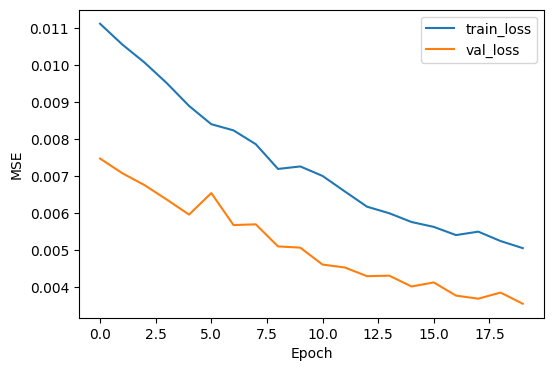

Seuil de reconstruction : 0.011041
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step
Accuracy : 0.8226164079822617
Precision: 0.8226164079822617
Recall   : 1.0
F1-score : 0.902676399026764


In [17]:
# 1) Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.show()

# 2) Définition du seuil (mean + 2*std du train loss)
train_mse = np.array(history.history['loss'])
threshold = train_mse.mean() + 2*train_mse.std()
print(f"Seuil de reconstruction : {threshold:.6f}")

# 3) Évaluation binaire
# Charger toutes les images anormales
anom_dirs = [d for d in os.listdir(DATA_DIR) if d!='Healthy Potatoes']
anom_imgs = np.vstack([ load_images_from_folder(os.path.join(DATA_DIR,d)) for d in anom_dirs ])
# Labels et données
X = np.vstack([ normal_images, anom_imgs ])
y = np.hstack([ np.zeros(len(normal_images)), np.ones(len(anom_imgs)) ])
# Reconstruction et MSE
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)
# Metrics
print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

In [18]:
# --- Calcul du threshold sur chaque image normale ---
# 1) MSE par image sur le train
Xn_pred = ae.predict(normal_images)
mse_train = np.mean((normal_images - Xn_pred)**2, axis=(1,2,3))

# 2) Seuil au 95ᵉ percentile
threshold = np.percentile(mse_train, 95)
print(f"Seuil 95pct MSE_train = {threshold:.6f}")

# 3) Réévaluation binaire
# (on réutilise anom_imgs, X, y de la cellule précédente)
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)

print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Seuil 95pct MSE_train = 0.200825
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy : 0.16851441241685144
Precision: 0.0
Recall   : 0.0
F1-score : 0.0


In [19]:
# --- Partie 2: Classification Multi‑Classe — Option 1 : Multi‑Seuils Adaptatifs ---

# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Calculer le seuil (95e pct) de la reconstruction pour chaque classe
thresholds = []
for idx, d in enumerate(class_dirs):
    Xc = imgs_list[idx]
    Xc_pred = ae.predict(Xc)
    mse_c = np.mean((Xc - Xc_pred)**2, axis=(1,2,3))
    th = np.percentile(mse_c, 95)
    thresholds.append(th)
    print(f"Seuil 95pct MSE_train pour '{d}' = {th:.6f}")

# 3) Classifier chaque image par la classe dont (seuil - mse) est maximal
X_all_pred = ae.predict(X_all)
mse_all = np.mean((X_all - X_all_pred)**2, axis=(1,2,3))
thresholds_arr = np.array(thresholds)
diff = np.abs(mse_all[None, :] - thresholds_arr[:, None])  # k x n
y_pred_thresh = np.argmin(diff, axis=0)

# 4) Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Multi‑Seuils Adaptatifs – Acc: %.3f  Préc: %.3f  Rcl: %.3f  F1: %.3f" %
      (accuracy_score(y_all, y_pred_thresh),
       precision_score(y_all, y_pred_thresh, average='macro'),
       recall_score(y_all, y_pred_thresh, average='macro'),
       f1_score(y_all, y_pred_thresh, average='macro')))
print("\nClassification report :\n", classification_report(y_all, y_pred_thresh, target_names=class_dirs))
print("Matrice de confusion :\n", confusion_matrix(y_all, y_pred_thresh))

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Seuil 95pct MSE_train pour 'Black Scurf' = 0.153680
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Seuil 95pct MSE_train pour 'Blackleg' = 0.174461
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Seuil 95pct MSE_train pour 'Common Scab' = 0.143406
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Seuil 95pct MSE_train pour 'Dry Rot' = 0.145371
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Seuil 95pct MSE_train pour 'Healthy Potatoes' = 0.200825
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Seuil 95pct MSE_train pour 'Miscellaneous' = 0.169713
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Seuil 95pct MSE_train pour 'Pink Rot' = 0.153072
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Multi‑Seuils Adaptatifs – Acc: 0.177  Préc: 0.025  Rcl: 0.143  F1: 0.043

Classification report :
                   precision    recall  f1-score   support

     Black Scurf       0.00      0.00

c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
ARI : 0.17798183093981604
Silhouette : 0.11712589


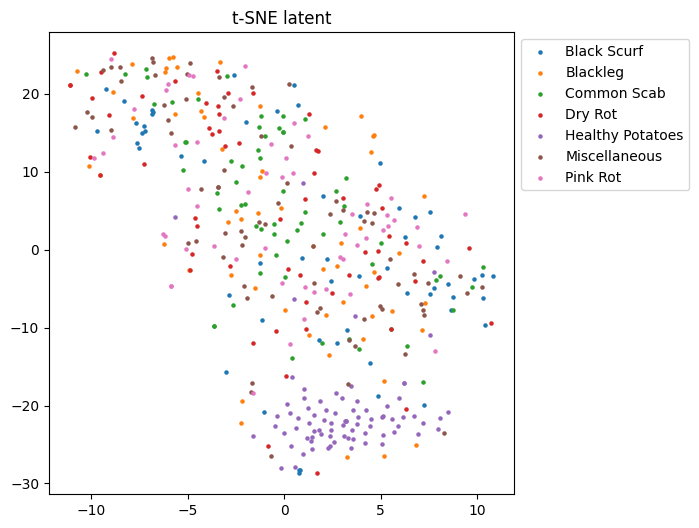

c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


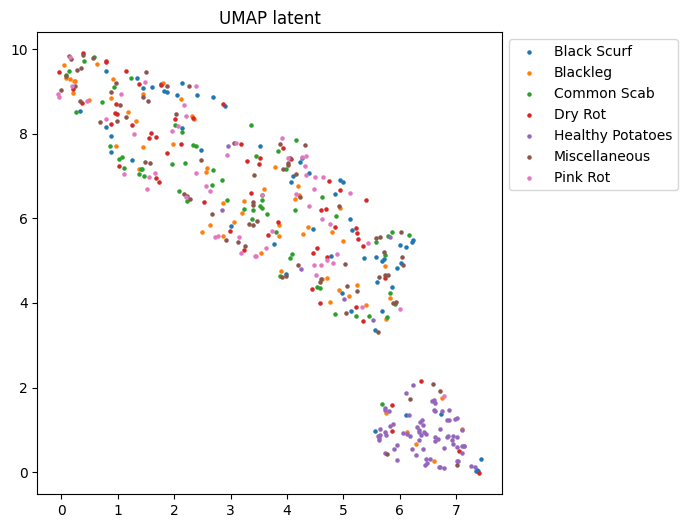

In [20]:
# --- Partie 2 : Clustering dans l’espace latent ---
# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Extraire le code latent via l’encodeur du CAE
encoder = tf.keras.Model(ae.input, ae.layers[4].output)
latent = encoder.predict(X_all)
latent_flat = latent.reshape(latent.shape[0], -1)

# 3) K‑means + métriques
n_clusters = len(class_dirs)
km = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_km = km.fit_predict(latent_flat)
print("ARI :", adjusted_rand_score(y_all, y_pred_km))
print("Silhouette :", silhouette_score(latent_flat, y_pred_km))

# 4) Visualisation t‑SNE & UMAP
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(z_tsne[idx,0], z_tsne[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("t-SNE latent"); plt.show()

umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(umap_proj[idx,0], umap_proj[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("UMAP latent"); plt.show()

In [21]:
# --- Bonus 1: PCA + IsolationForest (détection d’anomalies) ---
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 1) Flatten pour PCA et IsolationForest
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

iso = IsolationForest(contamination=len(normal_images)/len(X), random_state=42)
y_iso = iso.fit_predict(X_pca)
# IsolationForest : -1=anomalie, 1=inlier → on convertit
y_pred_if = (y_iso == -1).astype(int)

print("PCA+IF  – Acc:", accuracy_score(y, y_pred_if),
      "Préc:", precision_score(y, y_pred_if),
      "Rec:", recall_score(y, y_pred_if),
      "F1:", f1_score(y, y_pred_if))

# --- Bonus 2: Classification supervisée sur l’espace latent (SVM & RF) ---
# On réutilise latent_flat et y_all
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    latent_flat, y_all, test_size=0.2, random_state=42, stratify=y_all)

for name, clf in [("SVM", SVC()), ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))]:
    clf.fit(X_train_l, y_train_l)
    y_pred_l = clf.predict(X_test_l)
    print(f"{name} – Acc: {accuracy_score(y_test_l,y_pred_l):.3f}, "
          f"Prc: {precision_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"Rcl: {recall_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"F1: {f1_score(y_test_l,y_pred_l, average='macro'):.3f}")

PCA+IF  – Acc: 0.3458980044345898 Préc: 0.975 Rec: 0.21024258760107817 F1: 0.3458980044345898


c:\Users\med\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM – Acc: 0.341, Prc: 0.324, Rcl: 0.295, F1: 0.241
RandomForest – Acc: 0.495, Prc: 0.572, Rcl: 0.477, F1: 0.484
